# Stiff Problem

**강좌**: *수치해석 프로젝트*

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

## Stiff System
### 예제
Mass Spring Damper 로 구성된 운동방정식을 생각하자

:::{figure-md} markdown-fig
<img src="https://upload.wikimedia.org/wikipedia/commons/4/45/Mass_spring_damper.svg" alt="spring-damper-fig">

Spring-Damper System (From Wikimedia)
:::

$$
m \ddot{x} + c \dot{x} + k x = 0, ~~~x(0) = x_0, ~\dot{x} = 0
$$

이때 질량, Damper 계수 및 스프링 계수를 $m=1, c=1001, k=1000$로 하자.
이를 1계 미분방정식을 만들면 다음과 같다.

$$
\frac{d}{dt}{\left [
\begin{matrix}
x \\ \dot{x}
\end{matrix}
\right ]}
=
\left [
\begin{matrix}
0 & 1 \\
-k/m & -c/m
\end{matrix}
\right ]
\left [
\begin{matrix}
x \\ \dot{x}
\end{matrix}
\right ]
$$

이 System의 고유치 (Eigenvalue) 는

In [2]:
from scipy import linalg

In [3]:
a = np.array([[0, 1], [-1000, -1001]])
linalg.eig(a)

(array([   -1.+0.j, -1000.+0.j]),
 array([[ 7.07106781e-01, -9.99999500e-04],
        [-7.07106781e-01,  9.99999500e-01]]))

고유치가 1000배 차이가 나는 System이다.
이 방정식을 `solve_ivp` 로 해석해보면 다음과 같다.

In [4]:
from scipy.integrate import solve_ivp

In [5]:
solve_ivp?

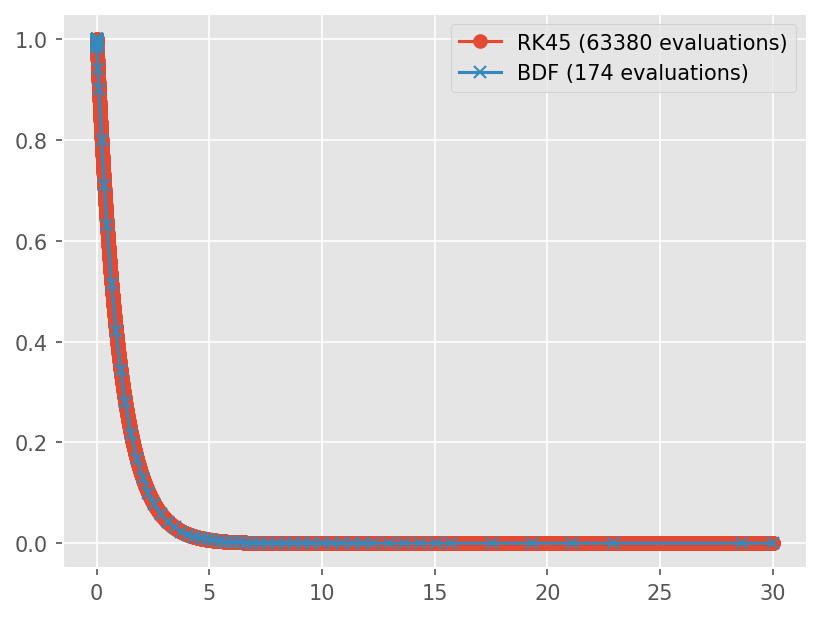

In [6]:
def f(t, y):
    return np.array([y[1], -1000*y[0] - 1001*y[1]])

# Solve IVP with RK45 and BDF
sol1 = solve_ivp(f, [0, 30], [1, 0])
sol2 = solve_ivp(f, [0, 30], [1, 0], method='BDF')

# Plot with Marker
plt.plot(sol1.t, sol1.y[0], marker='o')
plt.plot(sol2.t, sol2.y[0], marker='x')
plt.legend(['RK45 ({} evaluations)'.format(sol1.nfev), 'BDF ({} evaluations)'.format(sol2.nfev)])
plt.show()

Runge Kutta (RK45) 기법과 Backward Diffrence Formula (BDF)으로 해석한 결과 다음과 같은 차이가 있다.
- 두 기법 모두 Adaptive step size를 조절했음에도 RK45는 매우 작은 시간간격으로 계산한다.
- BDF 기법은 변화가 적은 영역에서 매우 큰 시간간격을 가져도 수치 안정성이 유지된다.

`solve_ivp` 도움말을 확인해보면 일반적인 문제에 대해서는 Runge-Kutta 기법을 사용하지만, Stiff system에서는 ``Radau``, ``BDF``, ``LSODA`` 를 사용할 것을 권장한다. 후자는 Implicit 기법이다.

### Stiff System 정의
이렇게 System의 전파 속도 (고유치)의 차이가 큰 문제를 Stiff System이라 한다. 대표적인 문제는 다음과 같다.

- 반응속도가 매우 다른 화학반응
- 공기역학에서 점성에 의한 경계층 유동

## Implicit Methods

Implicit 기법은 미분값을 현재 시간의 값이 아닌 미래 시간의 값으로 가정한 후 계산하는 방식이다. 대표적인 방법들은 다음과 같다.

- Implicit Euler Method 
- Crank Nicolson Method (Trapezoidal Method)
- Backward Difference Formula
- Diagonally Implicit Runge-Kutta Method

### Implicit Euler Method
Euler Explicit과 달리 미분항을 $t^{n+1}$ 에서 생각하자.

$$
\frac{y_{n+1} - y_n}{h} = f(t_{n+1}, y_{n+1})
$$

Model 방정식에 대해서는 다음과 같이 생각할 수 있다.

$$
y_{n+1} - y_n = h \lambda y_{n+1}
$$
$$
y_{n+1} = \frac{1}{1 - h \lambda} y_n = \sigma y_n
$$

여기서 $|\sigma| < 1$ 이므로, 항상 안정적이다.

$\lambda=0.5$ 이고 $y_0 = 1.0$ 일 때 $[0, 20]$ 까지 Explict Euler 와 Implicit Euler를 비교하자.

In [7]:
def f(t, y):
    return -0.5*y

In [8]:
def expliciteuler_v1(f, tspan, y0, dt=0.1):
    """
    Explicit Euler Method (ODE), High-order variant
    
    Parameters
    ----------
    f : function
        Derivative
    tpan : tuple
        initial and final time
    y0 : array
        initial guess
    dt : float
        Time step size
    
    Return
    ------
    t : array
        Time series
    y : array
        solutions
    """    
    # 시간 Array
    t0, te = tspan
    t = np.arange(t0, te+1e-10, dt)
    
    # Solution array
    y = np.empty((len(y0), len(t)))
    y[:, 0] = y0
    
    # Euler Explicit
    for i, ti in enumerate(t):
        if i > 0:
            y[:, i] = y[:, i-1] + dt*f(ti, y[:, i-1])
            
    return t, y

In [9]:
def impliciteuler_model(lam, tspan, y0, dt=0.1):
    """
    Implicit Euler Method (ODE)
    
    Parameters
    ----------
    lam : float
        Lambda for model equation
    tpan : tuple
        initial and final time
    y0 : array
        initial guess
    dt : float
        Time step size
    
    Return
    ------
    t : array
        Time series
    y : array
        solutions
    """    
    # 시간 Array
    t0, te = tspan
    t = np.arange(t0, te+1e-10, dt)
    
    # Solution array
    y = np.empty((len(y0), len(t)))
    y[:, 0] = y0
    
    # Implicit Euler model
    for i, ti in enumerate(t):
        if i > 0:
            y[:, i] = y[:, i-1] / (1 + lam*dt)
            
    return t, y

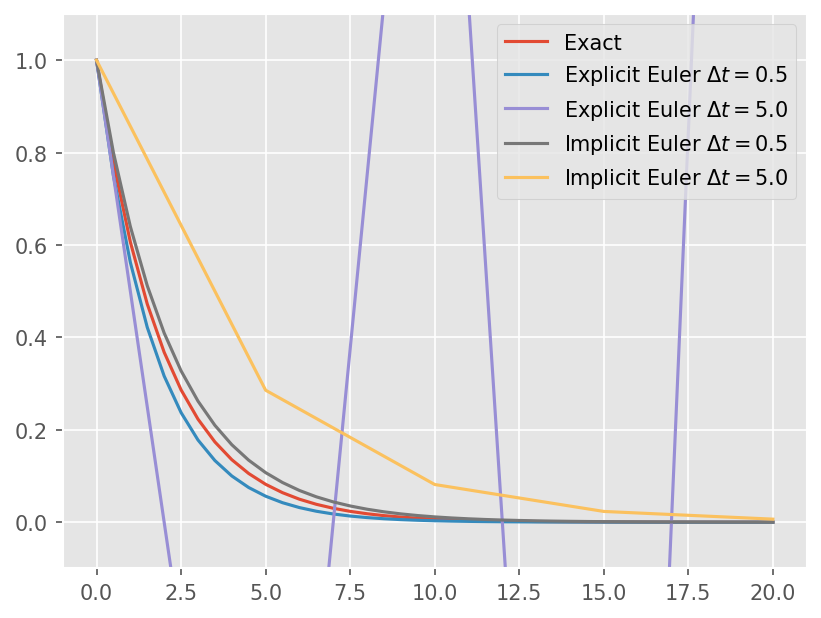

In [10]:
t, y = expliciteuler_v1(f, [0, 20], [1], dt=0.5)
plt.plot(t, np.exp(-0.5*t))
plt.plot(t, y[0])

t, y = expliciteuler_v1(f, [0, 20], [1], dt=5.0)
plt.plot(t, y[0])

t, y = impliciteuler_model(0.5, [0, 20], [1], dt=0.5)
plt.plot(t, y[0])

t, y = impliciteuler_model(0.5, [0, 20], [1], dt=5.0)
plt.plot(t, y[0])
plt.ylim(-0.1, 1.1)

plt.legend([
    'Exact', r'Explicit Euler $\Delta t=0.5$', r'Explicit Euler $\Delta t=5.0$',
    r'Implicit Euler $\Delta t=0.5$', r'Implicit Euler $\Delta t=5.0$'
])

### Linearization
일방적인 비선형 미분방정식에 대해 Implicit 방법을 적용하기 위해서는 선형화 (Linearization)이 필요하다.

$$
\frac{y_{n+1} - y_n}{h} = f(t_{n+1}, y_{n+1}) \approx f(t_{n+1}, y_n) + \frac{\partial f}{\partial y} 
\Delta y+ O((\Delta y)^2)
,~~~ \Delta y = y_{n+1} - y_n
$$

즉

$$
\left (\frac{1}{h} - \frac{\partial f}{\partial y} \right) \Delta y = f(t_{n+1}, y_n)
$$

- $\frac{\partial f}{\partial y}$ 를 모르는 경우 간단한 Finite Difference 공식으로 근사화 한다.

$$
\frac{\partial f}{\partial y} = \frac{f(t_{n+1}, y_n + \epsilon) - f(t_{n+1}, y_n)}{\epsilon}
$$

In [11]:
def impliciteuler_v1(f, tspan, y0, dt=0.1, dfdy=None):
    """
    Implicit Euler Method (Non-linear variant)
    
    Parameters
    ----------
    f : function
        Derivative
    tpan : tuple
        initial and final time
    y0 : array
        initial guess
    dt : float
        Time step size
    dfdy : function
        Jacobian
    
    Return
    ------
    t : array
        Time series
    y : array
        solutions
    """    
    # 시간 Array
    t0, te = tspan
    t = np.arange(t0, te+1e-10, dt)
    
    # Solution array
    y = np.empty((len(y0), len(t)))
    y[:, 0] = y0
    
    if dfdy:
        need_jacobian = False
    else:
        need_jacobian = True
    
    # Implicit Euler model
    for i, ti in enumerate(t):
        # 
        if need_jacobian:
            yi = y[:, i-1]
            eps = 1e-6
            dfdy = (f(ti, yi + eps) - f(ti, yi)) / eps
            
        if i > 0:
            dy = f(ti, y[:, i-1]) / (1/dt - dfdy)
            
            y[:, i] = y[:, i-1] +dy
            
    return t, y

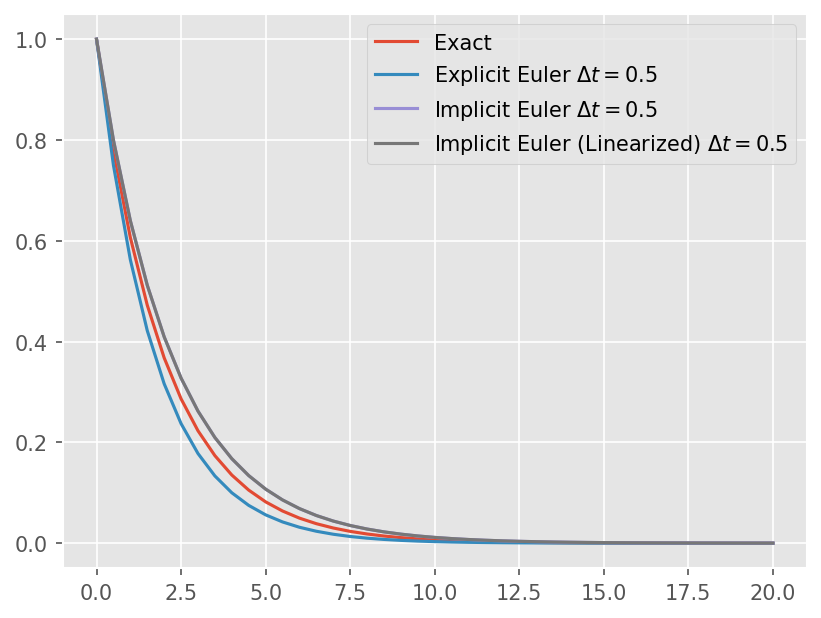

In [12]:
t, y = expliciteuler_v1(f, [0, 20], [1, 0], dt=0.5)
plt.plot(t, np.exp(-0.5*t))
plt.plot(t, y[0])

t, y = impliciteuler_model(0.5, [0, 20], [1, 0], dt=0.5)
plt.plot(t, y[0])

t, y = impliciteuler_v1(f, [0, 20], [1, 0], dt=0.5)
plt.plot(t, y[0])

plt.legend([
    'Exact', r'Explicit Euler $\Delta t=0.5$',
    r'Implicit Euler $\Delta t=0.5$', 
    r'Implicit Euler (Linearized) $\Delta t=0.5$', 
])

Sytem에 대해서는 $\frac{\partial f}{\partial y}$는 Jacboain Matrix로 계산한다.

$$
\Delta f = 
\left [
\begin{matrix}
\frac{\partial f_1}{\partial y_1} & \frac{\partial f_1}{\partial y_2} & ... & \frac{\partial f_1}{\partial y_n} \\
\frac{\partial f_2}{\partial y_1} & \frac{\partial f_2}{\partial y_2} & ... & \frac{\partial f_2}{\partial y_n} \\
... & ... & ... & ... \\
\frac{\partial f_n}{\partial y_1} & \frac{\partial f_n}{\partial y_2} & ... & \frac{\partial f_n}{\partial y_n} \\
\end{matrix}
\right ]
$$

Jacobian Matrix는 그냥 구하거나 각 항을 Finite difference method로 구할 수 있다.

#### 예제

Mass, Spring, Damper System에서 Jacobian Matrix는 다음과 같다.

$$
\frac{\partial f}{\partial y} =
\left [
\begin{matrix}
0 & 1 \\
-k/m & -c/m
\end{matrix}
\right ]
\left [
\begin{matrix}
x \\ \dot{x}
\end{matrix}
\right ]
$$

In [13]:
def impliciteuler_v2(f, dfdy, tspan, y0, dt=0.1):
    """
    Implicit Euler Method (Linear system)
    
    Parameters
    ----------
    f : function
        Derivative
    dfdy : function
        Jacobian
    tpan : tuple
        initial and final time
    y0 : array
        initial guess
    dt : float
        Time step size
    
    Return
    ------
    t : array
        Time series
    y : array
        solutions
    """
    # 시간 Array
    t0, te = tspan
    t = np.arange(t0, te+1e-10, dt)
    
    # Solution array
    y = np.empty((len(y0), len(t)))
    y[:, 0] = y0
    
    # Implicit Euler model
    for i, ti in enumerate(t):
        if i > 0:
            a = np.identity(len(y0))/dt - dfdy
            dy = np.linalg.solve(a, f(ti, y[:, i-1]))
            
            y[:, i] = y[:, i-1] +dy
            
    return t, y

In [14]:
def impliciteuler_v3(f, tspan, y0, dt=0.1, dfdy='none'):
    """
    Implicit Euler Method (Non-linear system)
    
    Parameters
    ----------
    f : function
        Derivative
    tpan : tuple
        initial and final time
    y0 : array
        initial guess
    dt : float
        Time step size
    dfdy : function
        Jacobian
    
    Return
    ------
    t : array
        Time series
    y : array
        solutions
    """
    # 시간 Array
    t0, te = tspan
    t = np.arange(t0, te+1e-10, dt)
    
    # Solution array
    ny = len(y0)
    y = np.empty((ny, len(t)))               
    y[:, 0] = y0
    
    if dfdy == 'none':
        need_jacobian = True
        eye = np.identity(len(y0))
    else:
        need_jacobian = False
    
    # Implicit Euler model
    for i, ti in enumerate(t):
        if i > 0:
            if need_jacobian:
                # Compute Jacobian
                yi = y[:, i-1]
                eps = 1e-6
                dfdy = np.array([
                    (f(ti, yi + e*eps) - f(ti, yi))/eps 
                    for e in eye
                ]).T
            
            a = np.identity(len(y0))/dt - dfdy
            dy = np.linalg.solve(a, f(ti, y[:, i-1]))
            
            y[:, i] = y[:, i-1] +dy
            
    return t, y

/tmp/ipykernel_11543/2654520036.py:2: RuntimeWarning: overflow encountered in scalar multiply
  return np.array([y[1], -1000*y[0] - 1001*y[1]])
/tmp/ipykernel_11543/1411676160.py:34: RuntimeWarning: invalid value encountered in add
  y[:, i] = y[:, i-1] + dt*f(ti, y[:, i-1])


(-0.1, 1.1)

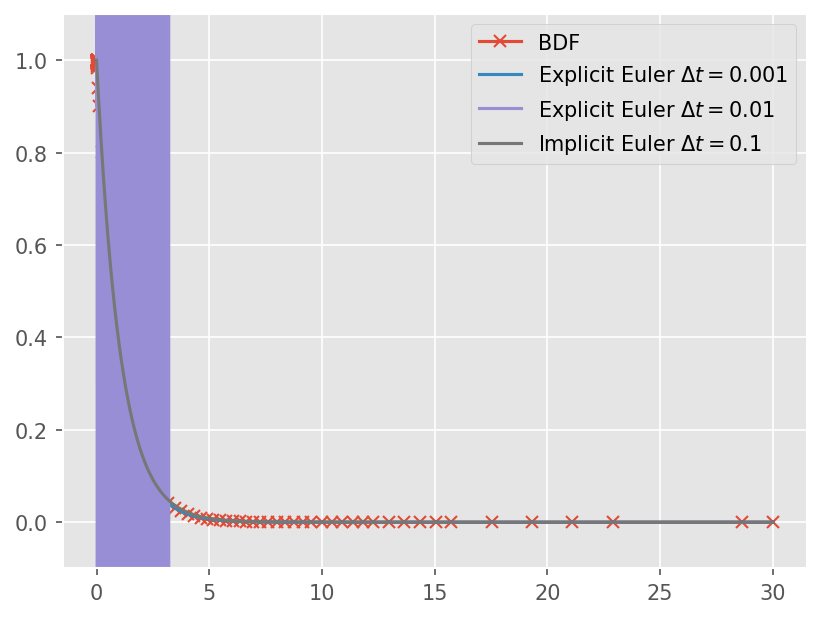

In [15]:
def f(t, y):
    return np.array([y[1], -1000*y[0] - 1001*y[1]])

jac = np.array([[0, 1], [-1000, -1001]])

plt.plot(sol2.t, sol2.y[0], marker='x')
t, y = expliciteuler_v1(f, [0, 30], [1, 0], dt=0.001)
plt.plot(t, y[0])

t, y = expliciteuler_v1(f, [0, 30], [1, 0], dt=0.01)
plt.plot(t, y[0])

#t, y = impliciteuler_v2(f, jac, [0, 30], [1, 0], dt=0.1)
t, y = impliciteuler_v3(f, [0, 30], [1, 0], dt=0.1)
plt.plot(t, y[0])

plt.legend([
    r'BDF', r'Explicit Euler $\Delta t=0.001$', r'Explicit Euler $\Delta t=0.01$',
    r'Implicit Euler $\Delta t=0.1$'
])

plt.ylim(-0.1, 1.1)